# GAN Project

I'm not sure exactly what I want to call it yet, but the goal is to make a webapp that uses GANs and Deep Learning to remove artifacts on images the user uploads. I wanted to make this to get some experience working with GANs as I think their applications are endless and really intresting, along with doing some web development that I don't have a ton of experience in.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

from PIL import Image, ImageDraw, ImageFont

In [3]:
torch.cuda.set_device(0)
print(f"Using GPU {torch.cuda.current_device()}")

Using GPU 0


## Utility Functions

In [4]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: NORM/x.name)
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [5]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [6]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(GEN/names[i].name)
            i += 1

In [7]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(PATH, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [8]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

## Data

I'll start by just focusing on training my GAN on portrait shots of people's faces. To get my dataset, I'll scrape Google Images to get a decent amount of Images, then create "crappy" versions of them from a custom function that my GAN will work on cleaning up and making close to the clean original.

In [9]:
os.makedirs('data/gan_project/normal', exist_ok=True)
# os.system("rm -rf data/gan_project/crappy") # TEMPORARY 
os.makedirs('data/gan_project/crappy', exist_ok=True)

PATH = Path('data/gan_project')
NORM = Path(PATH/'normal')
CRAP = Path(PATH/'crappy')

### Scraping Google Images

Downloading Images

In [ ]:
# os.system(f"touch {NORM}/image_urls.txt")
file = "image_urls.txt"

In [ ]:
download_images(PATH/file, NORM, max_pics=200)

Remove images that can't be opened

In [ ]:
verify_images(NORM, delete=True, max_size=500)

Convert images to PNG format

In [ ]:
for x in os.listdir(NORM):
    if x[-3:] != "png" and x[0] != ".":
        fn = x.split('.')[0]
        img = PIL.Image.open(NORM/x).convert("RGBA")
        img.save(str(NORM/fn) + ".png")
        os.system(f"rm {NORM/x}")

View Images

In [ ]:
il = ImageItemList.from_folder(NORM)

In [ ]:
il[:5]

In [ ]:
il[0]

### Crappifying Images

I'm stealing this term from Jeremy Howard's method of creating poor-quality images for a GAN to recreate. We need to think about what kind of artifacts are commonly seen in images for deciding how we want to "crappify" the high quality ones pulled from Google Images. Artifacts we may want to consider training the GAN for are:

- Transparent or opaque text
- Repeating pattens
- Low image resolution
- Color corrections

In [ ]:
il.items

In [ ]:
im_path = str(NORM/os.listdir(NORM)[0])
im_path

Overlays to add:
- 45 degree lines across entire image
- copyright symbol
- text in center and at random points around image
- transparent 'swirl' and 'camera' icons placed around image

In [ ]:
img = PIL.Image.open(im_path).convert("RGBA")
h, w = img.size

blank_img = Image.new('RGBA', img.size, (255,255,255,0))
draw_blank = ImageDraw.Draw(blank_img)
# draw_blank.line((0, 0) + img.size, width=5, fill=(255,255,255,50))
# draw_blank.line([(0+100,0),(h+100, w)], width=5, fill=(255,255,255,50))  
# draw_blank.line([(0,0),(h/9, w/9)], width=5, fill=(255,255,255,128))
# draw_blank.line([(h/4, w/4),(h/3,w/3)], width=5, fill=(255,255,255,128))

draw_blank.line([(0,0),(20,20)], width=5, fill=(255,255,255,128))
draw_blank.line([(40,40),(60,60)], width=5, fill=(255,255,255,128))
# draw_blank.arc([(0,0), (100,100)], start=0, end=200, width=3, fill=(255,255,255,128))
# draw_blank.arc([(0,0), (50,50)], start=0, end=200, width=3, fill=(255,255,255,128))

# fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 100)
# draw_blank.text((25,0), text="C", fill=(255,255,255,200), font=fnt)
# draw_blank.arc([(0,0), (100,100)], start=0, end=360, width=3, fill=(255,255,255,128))

line_length = 20
spacing = 20



out = Image.alpha_composite(img, blank_img)
# img.convert("JPEG")
# img.save(CRAP/'test.png')

In [ ]:
out

In [ ]:
def cross(img_path):
    img = PIL.Image.open(img_path).convert("RGBA")
    w,h = img.size

    blank_img = Image.new('RGBA', img.size, (255,255,255,0))
    draw_blank = ImageDraw.Draw(blank_img)
    
    draw_blank.line([(0,0),(w,h)], width=5, fill=(255,255,255,128))
    draw_blank.line([(w,0),(0,h)], width=5, fill=(255,255,255,128))
    
    file_name = img_path.split('/')[-1]
    out = Image.alpha_composite(img, blank_img)
    out.save(CRAP/file_name)
    
    
    return out

In [ ]:
cross(im_path)

In [ ]:
def crappify():
    for img in os.listdir(NORM):
        img_path = str(NORM/img)
#         print(img_path)
        cross(img_path)


In [ ]:
%%time
# Only call once
crappify()

In [ ]:
il = ImageItemList.from_folder(NORM)
il_c = ImageItemList.from_folder(CRAP)

In [ ]:
il

## Pretrain Generator

In [10]:
gc.collect()

60

In [11]:
arch = models.resnet34
bs,size = 32, 128
src = ImageImageList.from_folder(CRAP).random_split_by_pct(0.1, seed=42)

In [12]:
%%time
data_gen = get_data(bs,size)

CPU times: user 5.28 s, sys: 78.2 ms, total: 5.36 s
Wall time: 1.44 s


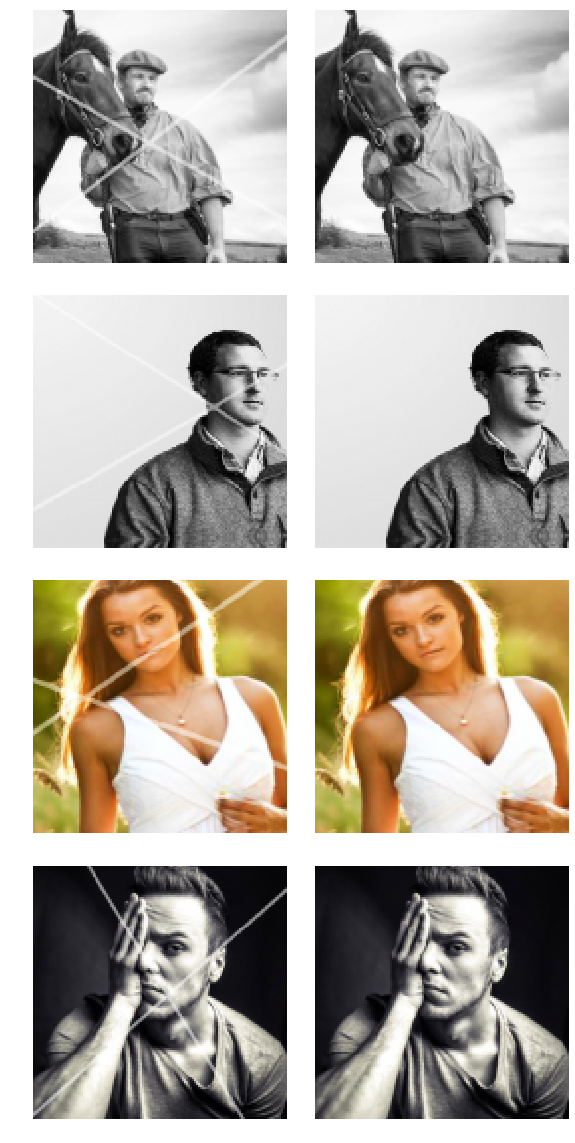

In [13]:
data_gen.show_batch(4)

In [14]:
wd = 1e-3

In [15]:
y_range = (-3., 3.)

In [16]:
loss_gen = MSELossFlat()

In [17]:
%%time
learn_gen = create_gen_learner()

CPU times: user 1min 34s, sys: 384 ms, total: 1min 35s
Wall time: 13.5 s


In [18]:
learn_gen.fit_one_cycle(10, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,1.568900,0.808200
2,0.908933,0.144700
3,0.626789,0.089716
4,0.468797,0.067237
5,0.370596,0.063364
6,0.304400,0.052533
7,0.256735,0.050857
8,0.220598,0.047488
9,0.192701,0.046852
10,0.170447,0.046591


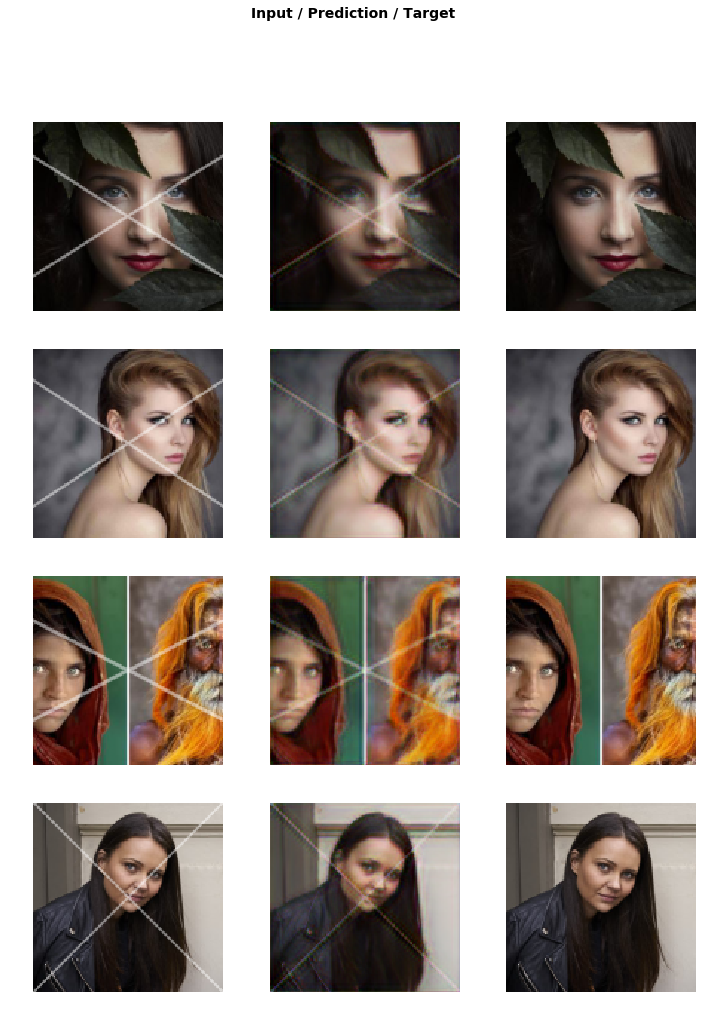

In [19]:
learn_gen.show_results(rows=4)

In [20]:
learn_gen.save('learn_gen_1')

### Save Generated Images

In [21]:
learn_gen.load('learn_gen_1');

In [22]:
name_gen = 'image_gen'
GEN = PATH/name_gen

In [23]:
GEN.mkdir(exist_ok=True)

In [24]:
save_preds(data_gen.fix_dl)

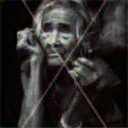

In [25]:
PIL.Image.open(GEN.ls()[0])

## Train Critic

In [26]:
learn_gen = None
gc.collect()

38596

Pretraining the critic on crappy vs non-crappy images

In [27]:
data_crit = get_crit_data([name_gen, 'normal'], bs=bs, size=size)

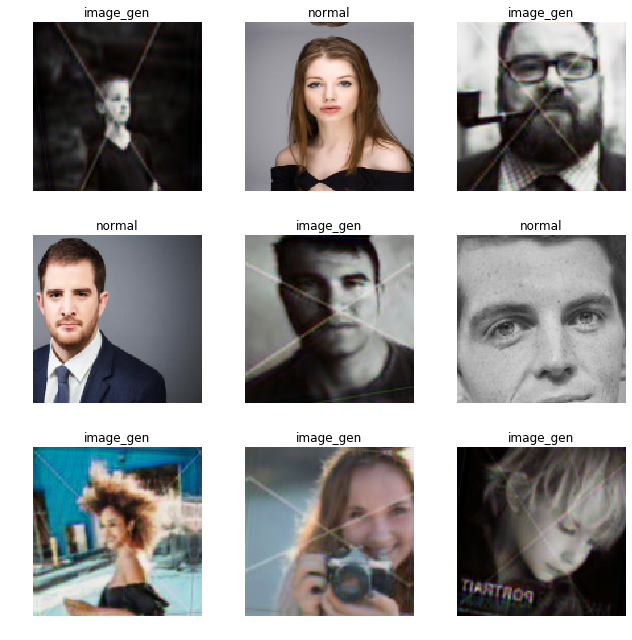

In [28]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [29]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [30]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [31]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand
1,0.719799,0.684342,0.540541
2,0.708513,0.694707,0.496216
3,0.703923,0.693621,0.529730
4,0.701433,0.702011,0.482162
5,0.698676,0.701078,0.480000
6,0.696226,0.701827,0.473514


In [32]:
learn_critic.save('critic_first')

## GAN

In [33]:
learn_crit = None
learn_gen = None
gc.collect()

15910

In [34]:
data_crit = get_crit_data(['crappy', 'normal'], bs=bs, size=size)

In [35]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic_first')

In [36]:
learn_gen = create_gen_learner().load('learn_gen_1')

Defining GAN Learner

In [37]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [38]:
lr = 1e-4

In [39]:
learn.fit(40, lr)

In [40]:
learn.save('gan-1c')

In [41]:
gc.collect()
learn.load('gan-1c');

Choosing your image size seems to be very limited at the moment, anything much higher than 200 pixels gives OOM errors regardless of batch size.

In [42]:
learn.data = get_data(16, 192)

In [43]:
learn.fit(10, lr/2)

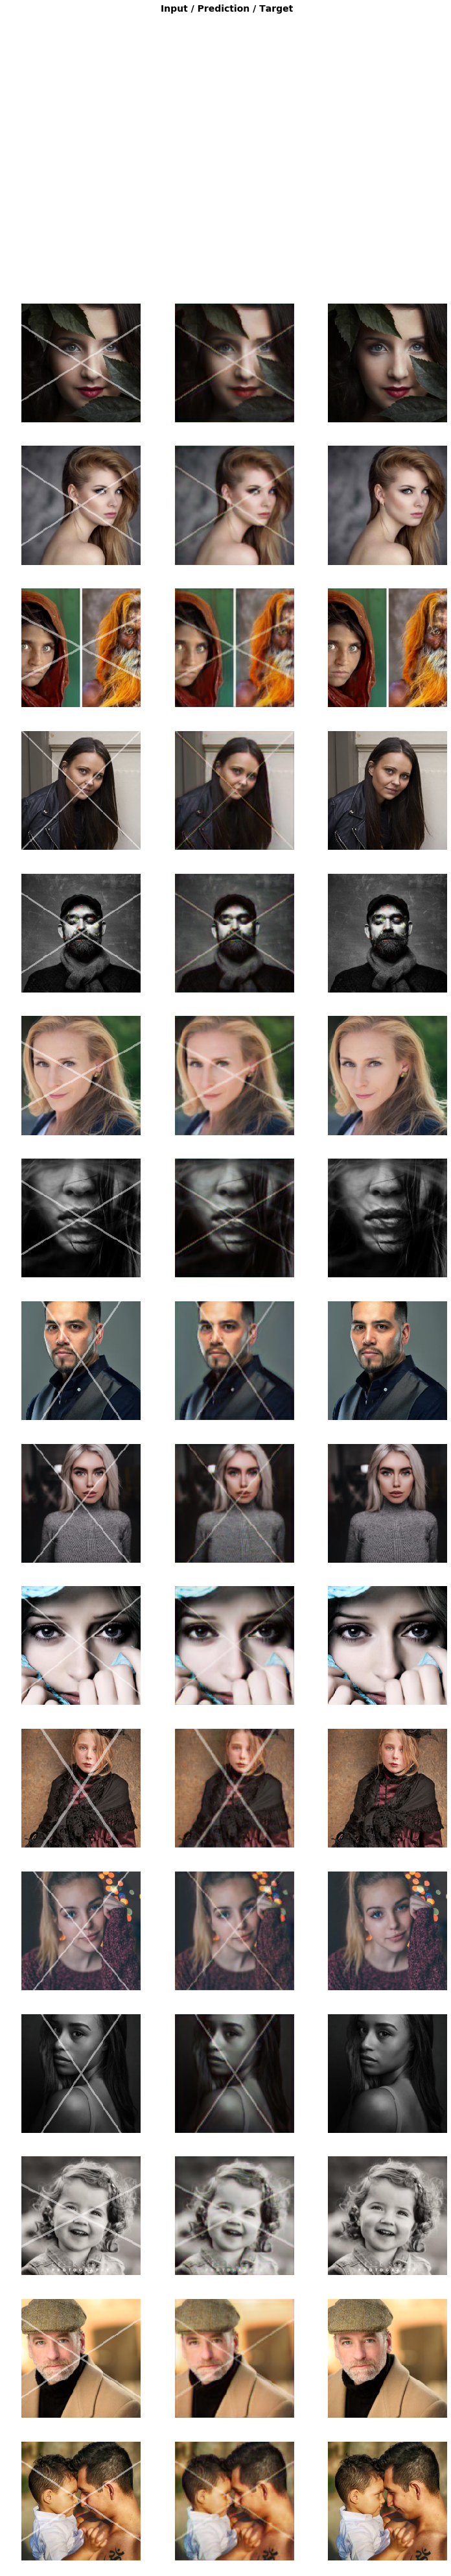

In [44]:
learn.show_results(rows=16)